In [1]:
import argparse
import logging
import os
import sys
import time
from collections import defaultdict
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim

from data_loader import data_loader
from models import *

import matplotlib.pylab as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [2]:
torch.backends.cudnn.benchmark = True

parser = argparse.ArgumentParser()
FORMAT = '[%(levelname)s: %(filename)s: %(lineno)4d]: %(message)s'
logging.basicConfig(level=logging.INFO, format=FORMAT, stream=sys.stdout)
logger = logging.getLogger(__name__)

# Dataset options
parser.add_argument('--delim', default='space')
parser.add_argument('--loader_num_workers', default=4, type=int)
parser.add_argument('--obs_len', default=20, type=int)
parser.add_argument('--pred_len', default=20, type=int)
parser.add_argument('--step', default=10, type=int)

# Optimization
parser.add_argument('--batch_size', default=64, type=int)
parser.add_argument('--num_iterations', default=10000, type=int)
parser.add_argument('--num_epochs', default=200, type=int)

# Model Options
parser.add_argument('--embedding_dim', default=16, type=int)
parser.add_argument('--num_layers', default=1, type=int)
parser.add_argument('--dropout', default=0, type=float)
parser.add_argument('--batch_norm', action='store_true')
parser.add_argument('--mlp_dim', default=1024, type=int)

# Generator Options
parser.add_argument('--encoder_h_dim_g', default=16, type=int)
parser.add_argument('--decoder_h_dim_g', default=16, type=int)
parser.add_argument('--clipping_threshold_g', default=0, type=float)
parser.add_argument('--g_learning_rate', default=1e-3, type=float)

# Output
parser.add_argument('--output_dir', default=os.getcwd())
parser.add_argument('--print_every', default=5, type=int)
parser.add_argument('--checkpoint_every', default=100, type=int)
parser.add_argument('--checkpoint_name', default='checkpoint')
parser.add_argument('--checkpoint_start_from', default=None)
parser.add_argument('--restore_from_checkpoint', default=1, type=int)
parser.add_argument('--num_samples_check', default=5000, type=int)

# Misc
parser.add_argument('--use_gpu', action='store_true')
parser.add_argument('--timing', default=0, type=int)
parser.add_argument('--gpu_num', default="0", type=str)

import sys
sys.argv = 'main.py'
sys.argv = sys.argv.split(' ')

args = parser.parse_args()

## Datasets

In [70]:
def plot_seq(ax, img, seq, color, linestyle='-', linewidth=1):                                                           
    '''                                                                                                                 
    Input:                                                                                                              
    - img: reference image                                                                                              
    - seq_ped: np/torch array of shape (traj_len, 2)                                                                    
    '''                                          
    ax.plot(seq[:-1,0], seq[:-1,1], color=color, 
            linewidth=linewidth, linestyle=linestyle)
    ax.arrow(seq[-2,0], seq[-2,1], seq[-1,0]-seq[-2,0], seq[-1,1]-seq[-2,1],
            head_width=2.5, head_length=2, fc=color, ec=color, linewidth=1)

In [4]:
logger.info("Initializing train dataset")
train_set, train_loader = data_loader(args, 'train', 'Biker')

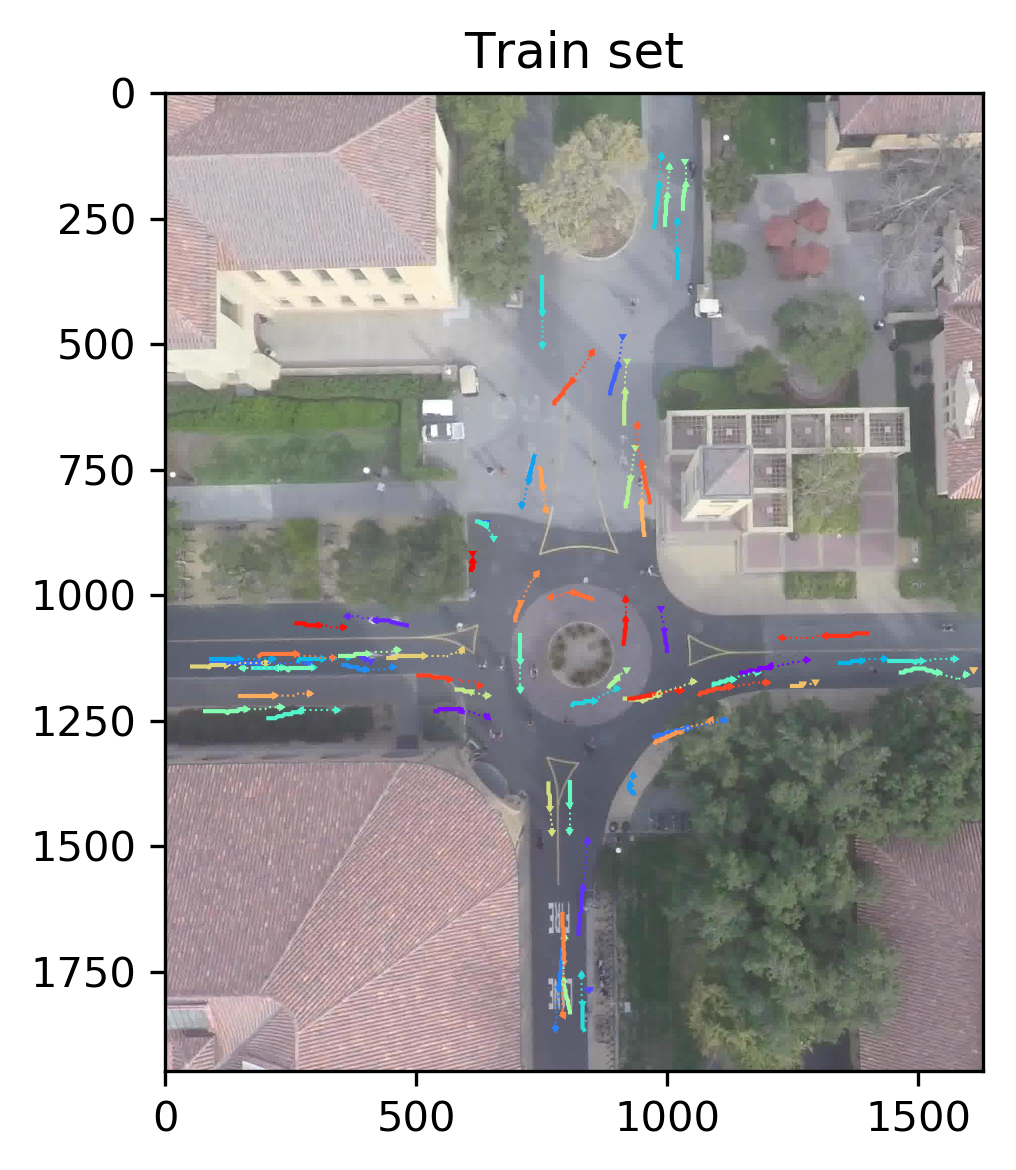

In [77]:
width, height = plt.figaspect(1) # 1.68
fig = plt.figure(figsize=(width,height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
colors = iter(cm.rainbow(np.linspace(0, 1, args.batch_size)))

img = np.array(Image.open('reference.jpg'))
batch = next(iter(train_loader))

obs_seq_list, pred_seq_list = batch[0], batch[1]

ax.imshow(img)

for seq, pred in zip(obs_seq_list, pred_seq_list):
    color = next(colors)
    plot_seq(ax, img, seq.numpy(), color=color)
    plot_seq(ax, img, pred.numpy(), color=color, linestyle=':', linewidth=0.5)
    
plt.title('Train set')
plt.tight_layout()

In [6]:
logger.info("Initializing val dataset")
val_set, val_loader = data_loader(args, 'val', 'Biker')

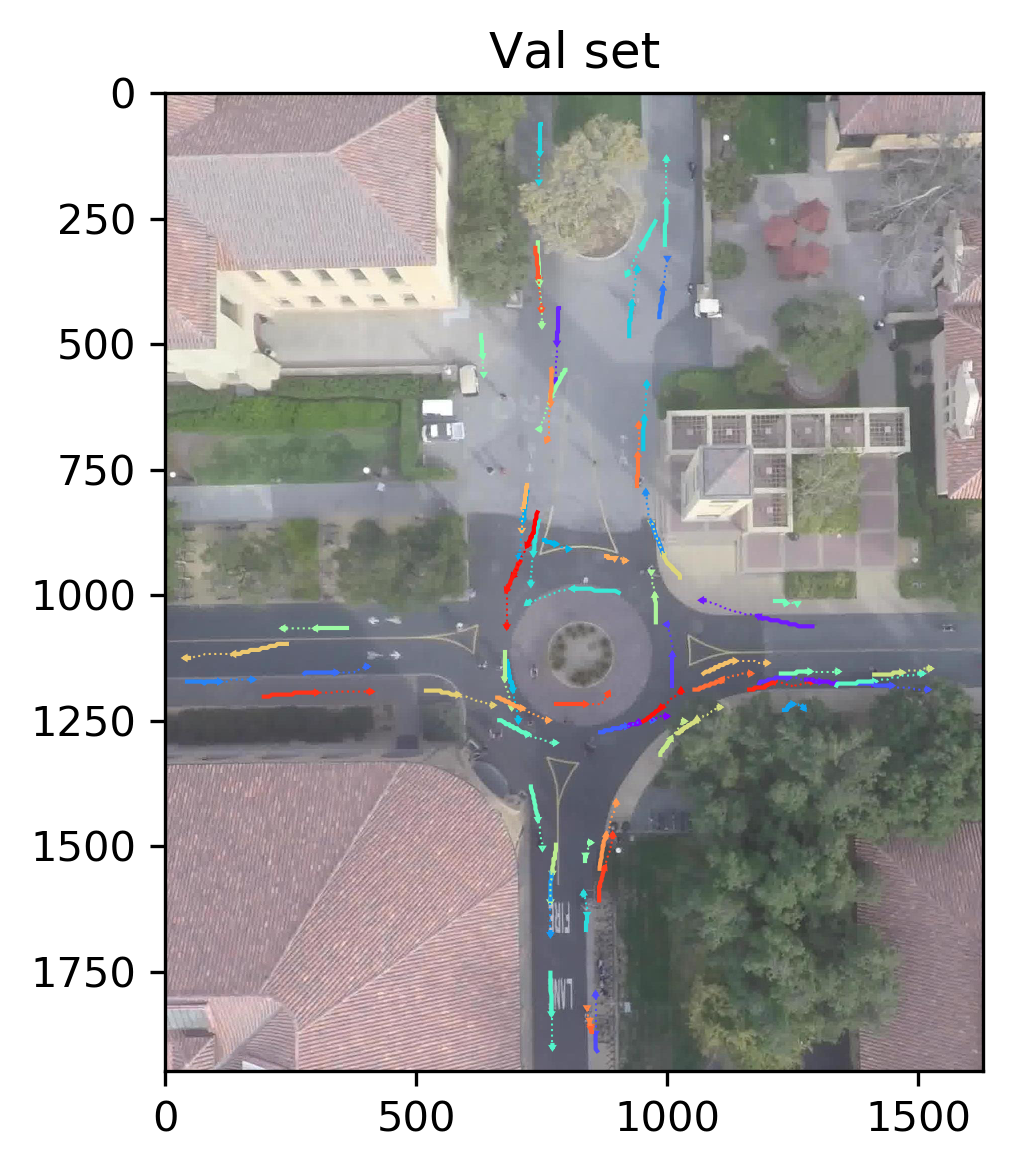

In [76]:
width, height = plt.figaspect(1) # 1.68
fig = plt.figure(figsize=(width,height), dpi=300)
ax = fig.add_subplot(1, 1, 1)
colors = iter(cm.rainbow(np.linspace(0, 1, args.batch_size)))

img = np.array(Image.open('reference.jpg'))
batch = next(iter(val_loader))

obs_seq_list, pred_seq_list = batch[0], batch[1]

ax.imshow(img)

for seq, pred in zip(obs_seq_list, pred_seq_list):
    color = next(colors)
    plot_seq(ax, img, seq.numpy(), color=color)
    plot_seq(ax, img, pred.numpy(), color=color, linestyle=':', linewidth=0.5)
    
plt.title('Val set')
plt.tight_layout()